https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os, sys

from custom_functions import *
from datetime import time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from imblearn.over_sampling import SMOTE

%load_ext autoreload
%autoreload 2
%matplotlib inline
pd.set_option('display.max_columns', 100)

RANDOM_STATE = 1000

raw_terry_path = os.path.join('..', 'data', 'raw', 'terry-stops.csv')
processed_data_path = os.path.join('..', 'data', 'processed')
UNKNOWN = 'Not provided'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv(raw_terry_path, dtype='str')

# Strip spaces, as relevant
for col in df.columns:
    df[col] = df[col].str.strip()

In [3]:
df['Stop Resolution'].value_counts()

Field Contact               18993
Offense Report              15646
Arrest                      11667
Referred for Prosecution      728
Citation / Infraction         179
Name: Stop Resolution, dtype: int64

In [4]:
df['Arrest Flag'].value_counts()

N    43754
Y     3459
Name: Arrest Flag, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47213 entries, 0 to 47212
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         47213 non-null  object
 1   Subject ID                47213 non-null  object
 2   GO / SC Num               47213 non-null  object
 3   Terry Stop ID             47213 non-null  object
 4   Stop Resolution           47213 non-null  object
 5   Weapon Type               47213 non-null  object
 6   Officer ID                47213 non-null  object
 7   Officer YOB               47213 non-null  object
 8   Officer Gender            47213 non-null  object
 9   Officer Race              47213 non-null  object
 10  Subject Perceived Race    47213 non-null  object
 11  Subject Perceived Gender  47213 non-null  object
 12  Reported Date             47213 non-null  object
 13  Reported Time             47213 non-null  object
 14  Initial Call Type     

In [6]:
# ------ CLEAN DATA ONE COLUMN AT A TIME -------

# Subject Age Group
df['Subject Age Group'].replace('-', UNKNOWN, inplace=True)

# Subject ID
df['Subject ID'].replace('-1', UNKNOWN, inplace=True)

# Weapon Type
weapon_type_dict = {'Firearm Other': 'Firearm', 
                    'Lethal Cutting Instrument': 'Knife', 
                    'Handgun': 'Firearm', 
                    '-': 'None', 
                    'Club, Blackjack, Brass Knuckles': 'Club/Melee', 
                    'Knife/Cutting/Stabbing Instrument': 'Knife', 
                    'Other Firearm': 'Firearm', 
                    'Rifle': 'Firearm', 
                    'Fire/Incendiary Device': 'Other', 
                    'Blunt Object/Striking Implement': 'Club/Melee', 
                    'Firearm (unk type)': 'Firearm', 
                    'Mace/Pepper Spray': 'Other', 
                    'None/Not Applicable': 'None', 
                    'Club': 'Club/Melee', 
                    'Taser/Stun Gun': 'Other', 
                    'Shotgun': 'Other', 
                    'Brass Knuckles': 'Club/Melee', 
                    'Automatic Handgun': 'Firearm', 
                    'Blackjack': 'Club/Melee', 
                    'Personal Weapons (hands, feet, etc.)': 'Club/Melee'}
df['Weapon Type'].replace(weapon_type_dict, inplace=True)



# Officer Year of Birth
df['Officer YOB'] = df['Officer YOB'].astype('int')



# Officer Race
race_dict = {'Unknown': np.nan, 
            'Not Specified': np.nan,
            '-': np.nan,
            'Other': np.nan, 
            'Unknown': np.nan}
df['Officer Race'].replace(race_dict, inplace=True)
df['Subject Perceived Race'].replace(race_dict, inplace=True)



# Subject Perceived Gender
gender_dict = {'Unable to Determine': np.nan,
              '-': np.nan,
               'Unknown': np.nan,
              'Gender Diverse (gender non-conforming and/or transgender)': 'Non-Binary',
               'N': 'Non-Binary',
               'M': 'Male',
               'F': 'Female'}
df['Subject Perceived Gender'].replace(gender_dict, inplace=True)
df['Officer Gender'].replace(gender_dict, inplace=True)



# Reported date and hour
df['Reported Date'] = df['Reported Date'].astype('datetime64')
    
    
# Call Type
call_type_dict = {'-': UNKNOWN,
                 'SCHEDULED EVENT (RECURRING)': UNKNOWN,
                 'TEXT MESSAGE': UNKNOWN}
df['Call Type'].replace(call_type_dict, inplace=True)
    
    
# Frisk Flag
df['Frisk Flag'].replace('-', np.nan, inplace=True)

# Precinct
precinct_dict = {'-': UNKNOWN,
                'FK ERROR': UNKNOWN,
                 'Unknown': UNKNOWN,
                'SouthWest': 'Southwest'}
df['Precinct'].replace(precinct_dict, inplace=True)


# Sector
df['Sector'].replace(['99', '-'], UNKNOWN, inplace=True)

# Beat
df['Beat'].replace(['S', '99', '-'], UNKNOWN, inplace=True)

# Feature Engineering

### Age group manipulation

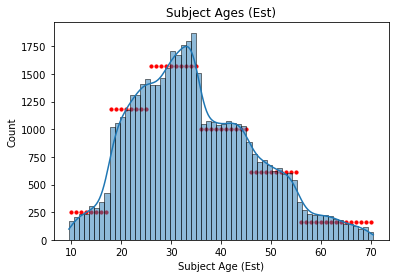

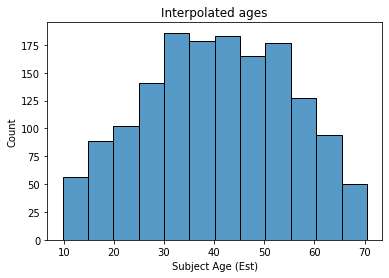

In [7]:
# ------ ESTIMATE SUBJECT AGE ------

np.random.seed(RANDOM_STATE)

df['Subject Age Group'].replace('-', UNKNOWN, inplace=True)

years_in_category = {'1 - 17': [10, 17],
'18 - 25': [18, 25],
'26 - 35': [26, 35],
'36 - 45': [36, 45],
'46 - 55': [46, 55],
'56 and Above': [56, 70]}

def predict_ages():
    avg, std, x, y = calculate_mean_and_std()
    
    ages = []
    for age_categorical in df['Subject Age Group']:
        age = predict_age_from_category(age_categorical, avg, std)
        ages.append(age)
    return ages, x, y


def calculate_mean_and_std():
    xy = {}
    
    age_group_counts = dict(df['Subject Age Group'].value_counts())
    
    for age_group in df['Subject Age Group'].replace(UNKNOWN, np.nan).dropna().unique():
        age_range_list = set_range(age_group)
        age_range_ct = age_group_counts[age_group]
        
        for item in age_range_list:
            xy[item] = int(age_range_ct/len(age_range_list))
    
    x = np.array(list(xy.keys()))
    y = np.array(list(xy.values()))
    avg = x.mean()
    std = x.std()
    return avg, std, x, y



def set_range(age_range):
    age_range = years_in_category[age_range]
    start = age_range[0]
    stop = age_range[1]
    return np.linspace(start, stop, stop-start+1)



def predict_age_from_category(bucket, avg, std):

    if bucket == UNKNOWN:
        year_range = np.array(list(years_in_category.values())).flatten()
        min_age = year_range.min()
        max_age = year_range.max()
    else:
        year_range = years_in_category[bucket]
        min_age = year_range[0]
        max_age = year_range[1]
    age = 0
    while ((age <= min_age-0.5) or (age > max_age+0.5)):
        age = np.random.normal(avg, std)
    return age


plt.figure()
df['Subject Age (Est)'], x, y = predict_ages()
sns.histplot(df['Subject Age (Est)'], bins=60, kde=True);
plt.scatter(x, y, c='r', s=10)
plt.title('Subject Ages (Est)')


plt.figure()
plt.title('Interpolated ages')
interpolated_rows = df.loc[df['Subject Age Group'] == UNKNOWN]
sns.histplot(interpolated_rows['Subject Age (Est)'], bins=12);

In [8]:
# Interpolate missing 'Subject Age Group' values based on this new Estimated Age column
# Essentially, finding a better way to impute than just the median or mean. 
# Instead, it samples from the calculated normal distribution

age_cats = [(17.5, '1 - 17'), (25.5, '18 - 25'), (35.5, '26 - 35'), (45.5, '36 - 45'), (55.5, '46 - 55'), (100, '56 and Above')]

age_groups = []
for i, item in enumerate(df['Subject Age Group']):
    if item != UNKNOWN:
        age_groups.append(item)
    else:
        x = df.iloc[i]['Subject Age (Est)']
        for cat in age_cats:
            if x <= cat[0]:
                age_groups.append(cat[1])
                break
            
df['Subject Age Group'] = age_groups

In [9]:
# Engineer new features

# Calculate Officer Age
if 'Officer YOB' in df.columns:
    df['Officer Age'] = df['Reported Date'].apply(lambda x: x.year) - df['Officer YOB']
    df['Officer Age'] = df['Officer Age'].apply(lambda x: np.nan if x > 100 else x)
    df.drop('Officer YOB', axis=1, inplace=True)

    
# Determine whether or not weapon was involved
#has_weapon = lambda x: 'No' if x == 'None' else 'Yes'
df['Weapon (Y/N)'] = (df['Weapon Type'] != 'None').astype('int')


# Calculate the number of stops per subject
if 'Subject ID' in df.columns:
    offense_ct_dict = dict(df['Subject ID'].value_counts())
    df['Offense Count'] = df['Subject ID'].map(offense_ct_dict)
    # Identify whether a subject has been involved in multiple stops
    df['Repeat Offender (Y/N)'] = (df['Offense Count'] > 1).astype('int')
    # Drop "Offense Count" for now given the number of missing values
    if 'Offense Count' in df:
        df.drop('Offense Count', axis=1, inplace=True)
    df.drop('Subject ID', axis=1, inplace=True)


# Identify whether race of officer is same as race of subject
df['Same Race (Y/N)'] = (df['Officer Race'] == df['Subject Perceived Race']).astype('int')

# Identify whether gender of officer is same as gender of subject
df['Same Gender (Y/N)'] = (df['Officer Gender'] == df['Subject Perceived Gender']).astype('int')

# Rename columns and drop 'na' rows
if 'Arrest Flag' in df.columns:
    df['Arrest (Y/N)'] = (df['Arrest Flag'] == 'Y').astype('int')
    df.drop('Arrest Flag', axis=1, inplace=True)
    
if 'Frisk Flag' in df.columns:
    df['Frisk (Y/N)'] = (df['Frisk Flag'] == 'Y').astype('int')
    df.drop('Frisk Flag', axis=1, inplace=True)
    
# Stop resolution
df['Stop Resolution: Arrest (Method2)'] = (df['Stop Resolution'] == 'Arrest').astype('int')


# Revisiting subject perceived gender
# Difficult decision to make, but with a sample size of only 5 people, the 
# amount of data is insufficient to provide a statistically significant understanding
# of how non-binary perception affects arrest rate
df['Subject Perceived Gender'].replace('Non-Binary', np.nan, inplace=True)


# Optionally categorize 'Officer Squad'
# Officer Squad

In [10]:
# Remove missing values and reset index
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

# Graphical EDA

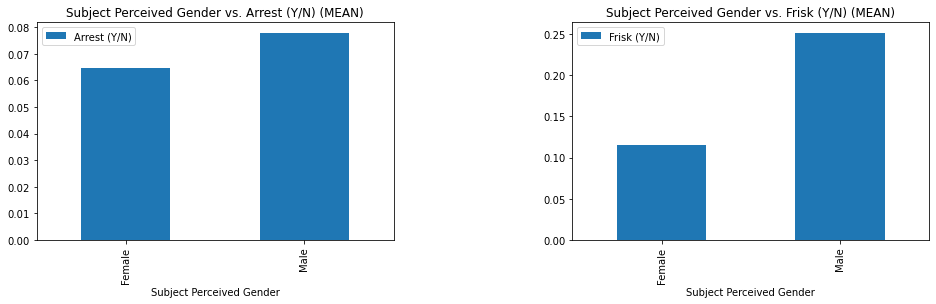

  Subject Perceived Gender  Arrest (Y/N)  Frisk (Y/N)
1                     Male      0.078036     0.252090
0                   Female      0.064598     0.115259
--------------------------------------------------------------------




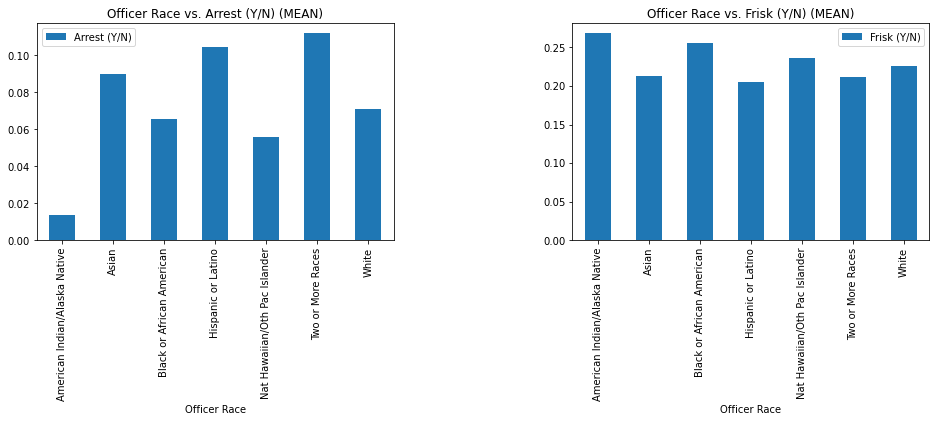

                    Officer Race  Arrest (Y/N)  Frisk (Y/N)
5              Two or More Races      0.111937     0.211631
3             Hispanic or Latino      0.104302     0.204545
1                          Asian      0.089989     0.213161
6                          White      0.070911     0.225288
2      Black or African American      0.065380     0.255293
4  Nat Hawaiian/Oth Pac Islander      0.055980     0.236641
0  American Indian/Alaska Native      0.013937     0.268293
--------------------------------------------------------------------




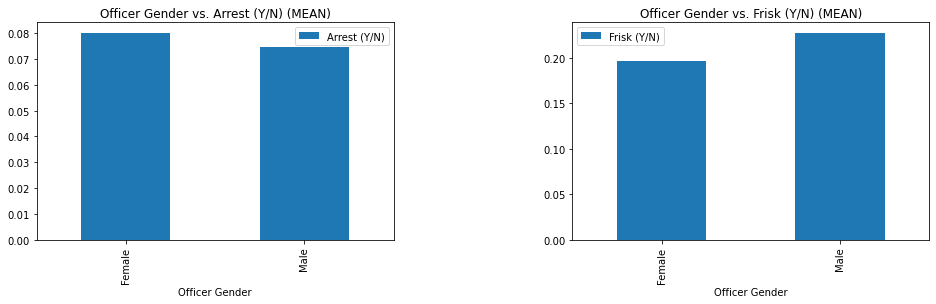

  Officer Gender  Arrest (Y/N)  Frisk (Y/N)
0         Female      0.080199     0.196714
1           Male      0.074682     0.227875
--------------------------------------------------------------------




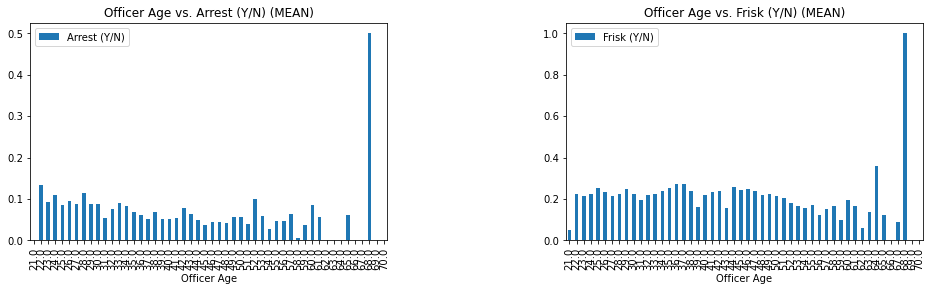

    Officer Age  Arrest (Y/N)  Frisk (Y/N)
47         68.0      0.500000     1.000000
1          22.0      0.134783     0.226087
7          28.0      0.115628     0.222222
3          24.0      0.109669     0.221934
31         52.0      0.099010     0.181518
5          26.0      0.095911     0.231701
2          23.0      0.092757     0.214740
12         33.0      0.091320     0.222954
8          29.0      0.087809     0.246803
6          27.0      0.087756     0.214398
9          30.0      0.086922     0.222887
4          25.0      0.085799     0.253254
39         60.0      0.084507     0.197183
13         34.0      0.083333     0.238889
21         42.0      0.077482     0.238499
11         32.0      0.076569     0.219665
17         38.0      0.068665     0.236944
14         35.0      0.068168     0.253112
36         57.0      0.064356     0.153465
22         43.0      0.063903     0.158895
44         65.0      0.062500     0.125000
15         36.0      0.062447     0.272027
32         

In [11]:
# BAR GRAPHS FOR ***AVERAGE OR SUM*** OF METRICS

df_graphical = pd.concat([df, pd.get_dummies(df['Stop Resolution'], prefix='Resolution')], axis=1)

# Average metrics by age group
x_axis = 'Subject Age Group'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']#, 'Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=False)

# Average metrics by subject race
x_axis = 'Subject Perceived Race'
#y_axis = ['Resolution_Arrest', 'Resolution_Citation / Infraction', 'Resolution_Field Contact', 'Resolution_Offense Report', 'Resolution_Referred for Prosecution']
#bar_plot(df_graphical, x_axis, y_axis, 'sum', verbose=True)

# Gender metrics
x_axis = 'Subject Perceived Gender'
y_axis = ['Arrest (Y/N)', 'Frisk (Y/N)']
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer race
x_axis = 'Officer Race'
bar_plot(df_graphical, x_axis, y_axis, 'mean',verbose=True)

# Officer gender
x_axis = 'Officer Gender'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Officer age
x_axis = 'Officer Age'
bar_plot(df_graphical, x_axis, y_axis, 'mean', verbose=True)

# Refine dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40672 entries, 0 to 40671
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Subject Age Group                  40672 non-null  object        
 1   GO / SC Num                        40672 non-null  object        
 2   Terry Stop ID                      40672 non-null  object        
 3   Stop Resolution                    40672 non-null  object        
 4   Weapon Type                        40672 non-null  object        
 5   Officer ID                         40672 non-null  object        
 6   Officer Gender                     40672 non-null  object        
 7   Officer Race                       40672 non-null  object        
 8   Subject Perceived Race             40672 non-null  object        
 9   Subject Perceived Gender           40672 non-null  object        
 10  Reported Date                     

In [17]:
continuous_columns

Index(['Reported Date', 'Subject Age (Est)', 'Officer Age', 'Weapon (Y/N)',
       'Repeat Offender (Y/N)', 'Same Race (Y/N)', 'Same Gender (Y/N)',
       'Arrest (Y/N)', 'Frisk (Y/N)', 'Stop Resolution: Arrest (Method2)'],
      dtype='object')

In [18]:
# Refine dataset to continuous and OHE values

# Separate columns by type
obj_columns = df.select_dtypes('object').columns
continuous_columns = df.drop(obj_columns, axis=1).columns

# Determine which columns are most valuable to OHE
# based on small enough number of values
cols_to_ohe = []
for col in obj_columns:
    if len(df[col].value_counts().index) < 30:
        cols_to_ohe.append(col)

df_refined = pd.concat([df[continuous_columns], df[cols_to_ohe]], axis=1)
df_refined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40672 entries, 0 to 40671
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Reported Date                      40672 non-null  datetime64[ns]
 1   Subject Age (Est)                  40672 non-null  float64       
 2   Officer Age                        40672 non-null  float64       
 3   Weapon (Y/N)                       40672 non-null  int32         
 4   Repeat Offender (Y/N)              40672 non-null  int32         
 5   Same Race (Y/N)                    40672 non-null  int32         
 6   Same Gender (Y/N)                  40672 non-null  int32         
 7   Arrest (Y/N)                       40672 non-null  int32         
 8   Frisk (Y/N)                        40672 non-null  int32         
 9   Stop Resolution: Arrest (Method2)  40672 non-null  int32         
 10  Subject Age Group                 

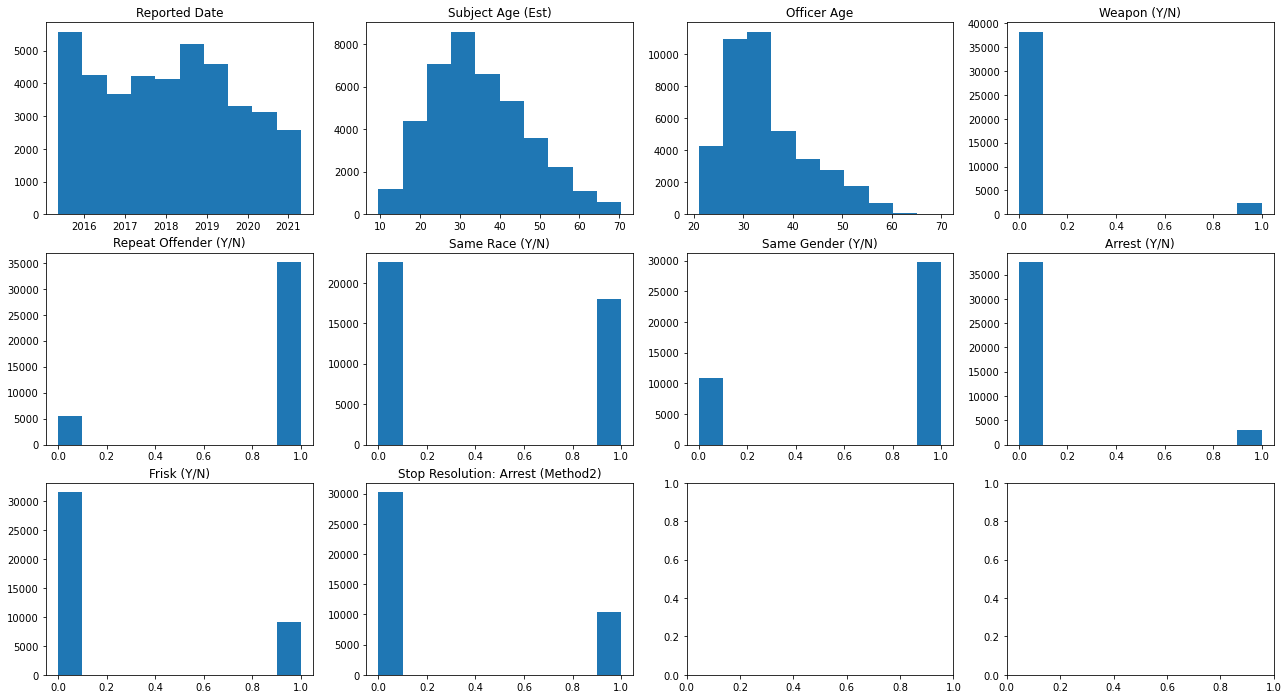

In [19]:
nrows = int(np.ceil(len(continuous_columns)/4))
fig, axes = plt.subplots(ncols=4, nrows=nrows, figsize=(22, 4*nrows))

for ax, col in zip(axes.flatten(), continuous_columns):
    ax.hist(df_refined[col])
    ax.set_title(col)

# Begin encoding and modeling

In [20]:
# OPTIONAL APPROACH: REMOVE ROWS WITH ANY UNKNOWNS (precinct, mostly)
# df_refined_no_nas = df_refined.copy()
# for col in df_refined_no_nas.columns:
#     df_refined_no_nas.replace(UNKNOWN, np.nan, inplace=True)

# df_refined_no_nas.dropna(inplace=True)
# df_refined_no_nas.info()

In [26]:
# Split data
y_label_v1 = 'Arrest (Y/N)'
y_label_v2 = 'Stop Resolution: Arrest (Method2)'
X = df_refined.drop([y_label_v1,
                     y_label_v2, 
                     'Stop Resolution', 
                     'Frisk (Y/N)', 
                     'Reported Date', 
                     'Subject Age Group', 
                     'Call Type', 
                     'Precinct',
                     'Sector'], axis=1)
y = df_refined[y_label_v2]

X, X_test, y, y_test = train_test_split(X, y, random_state = RANDOM_STATE)

# Remove temptation to touch test dataset
test_data = {'X_test': X_test, 'y_test': y_test}
with open (os.path.join(processed_data_path, 'test_data.pickle'), 'wb') as f:
    pickle.dump (test_data, f)
X_test = None
y_test = None
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

# Declare object to hold history of all model runs
model_history = ModelHistory()

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30504 entries, 0 to 30503
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age (Est)         30504 non-null  float64
 1   Officer Age               30504 non-null  float64
 2   Weapon (Y/N)              30504 non-null  int32  
 3   Repeat Offender (Y/N)     30504 non-null  int32  
 4   Same Race (Y/N)           30504 non-null  int32  
 5   Same Gender (Y/N)         30504 non-null  int32  
 6   Weapon Type               30504 non-null  object 
 7   Officer Gender            30504 non-null  object 
 8   Officer Race              30504 non-null  object 
 9   Subject Perceived Race    30504 non-null  object 
 10  Subject Perceived Gender  30504 non-null  object 
dtypes: float64(2), int32(4), object(5)
memory usage: 2.1+ MB


In [28]:
# --- BASELINE MODEL ---
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
X_numeric = X.select_dtypes(exclude='object')
model.fit(X_numeric, y)
model_history.add_results(model, X_numeric, y, verbose=True)

baseline


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline


In [30]:
# --- ENCODE AND SCALE ---

# ENCODE 'OBJECT' DATATYPES
ohe = OneHotEncoder(drop='first', sparse=False)
X_obj = X.select_dtypes(include='object')
ohe.fit(X_obj)

X_obj_ohe = ohe.transform(X_obj)
col_names_ohe = ohe.get_feature_names(X_obj.columns)
X_obj_ohe = pd.DataFrame(X_obj_ohe, columns = col_names_ohe)
X_numeric = X.drop(X_obj.columns, axis=1)
X_ohe_num = pd.concat([X_obj_ohe, X_numeric], axis=1)

ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X_ohe_num), columns = X_ohe_num.columns)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [31]:
# --- RUN LOGISTIC REGRESSION MODEL WITH CROSS-VALIDATION ---
model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model.fit(X_resampled, y_resampled)
model_history.add_results(model, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE);


# --- ADD GRID SEARCH ---
param_grid = {'C': np.logspace(-4, 4, 25)}
grid_search = GridSearchCV(model, param_grid)
grid_search.fit(X_resampled, y_resampled)
model_history.add_results(grid_search, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE);

logreg, all adjustments


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"


grid search version of above model


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"
2,GridSearchCV(estimator=LogisticRegression(max_...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.539138,0.558232,grid search version of above model


In [ ]:
# --- IMPLEMENT K-NEAREST NEIGHBORS ---
# model = KNeighborsClassifier(random_state=RANDOM_STATE)
# model.fit(X_resampled, y_resampled)
# model_history.add_results(model, X_resampled, y_resampled, verbose=True, random_state=RANDOM_STATE)

# --- ADD GRID SEARCH ---
# params = {'n_neighbors': np.arange(1,10, 2), 'p': [1,2], 'leaf_size':[3, 5]}
# model = KNeighborsClassifier()#n_neighbors=2, leaf_size=2)
# model.fit(X_resampled, y_resampled)
# grid_search = GridSearchCV(model, params)
# grid_search.fit(X_resampled, y_resampled)
# model_history.add_results(grid_search, X_resampled, y_resampled, verbose=True, cv=5)

DT w/o grid search


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"
2,GridSearchCV(estimator=LogisticRegression(max_...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.539138,0.558232,grid search version of above model
3,"DecisionTreeClassifier(max_depth=5, random_sta...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.601759,0.564624,DT w/o grid search


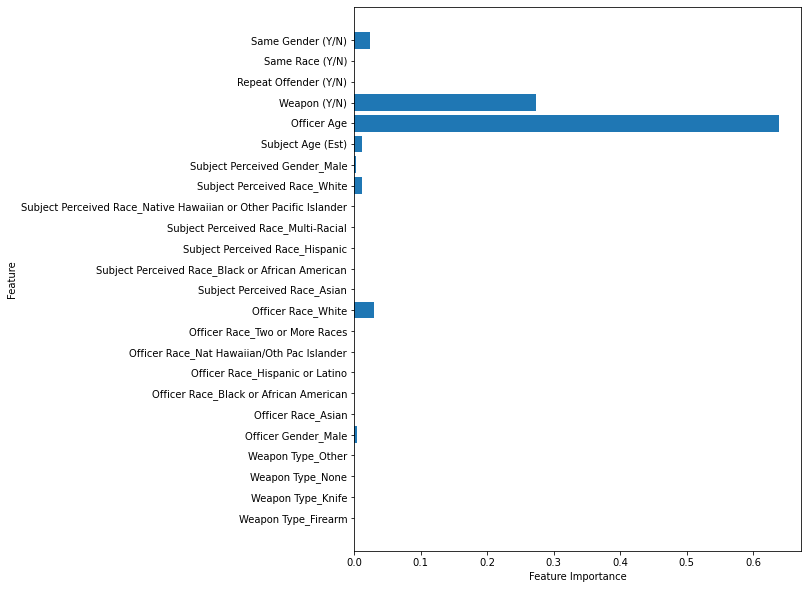

In [33]:
# --- IMPLEMENT DECISION TREE ---
tree = DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)
tree.fit(X_resampled, y_resampled)
tree.feature_importances_

def plot_feature_importances(model, data):
    n_features = data.shape[1]
    plt.figure(figsize=(8, 10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns.values)
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

plot_feature_importances(tree, X_resampled)

model_history.add_results(tree, X_resampled, y_resampled, verbose=True, cv=3)

# ---  TO DO: ADD GRID SEARCH FOR DECISION TREE! ---

In [38]:
# --- IMPLEMENT RANDOM FOREST ---
forest = RandomForestClassifier(max_depth=5, random_state=RANDOM_STATE)
forest.fit(X_resampled, y_resampled)
model_history.add_results(forest, X_resampled, y_resampled, verbose=True, cv=3, random_state=RANDOM_STATE)

# --- ADD GRID SEARCH TO RANDOM FOREST ---
param_grid = {
    'n_estimators': [10, 30],#, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

model = RandomForestClassifier(random_state=RANDOM_STATE)
model_grid = GridSearchCV(model, param_grid)
model_grid.fit(X_resampled, y_resampled)
model_history.add_results(model_grid, X_resampled, y_resampled, verbose=True, cv=5)

same as above


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"
2,GridSearchCV(estimator=LogisticRegression(max_...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.539138,0.558232,grid search version of above model
3,"DecisionTreeClassifier(max_depth=5, random_sta...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.601759,0.564624,DT w/o grid search
4,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,RF w/o grid
5,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,no change from above
6,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,same as above


added grid


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"
2,GridSearchCV(estimator=LogisticRegression(max_...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.539138,0.558232,grid search version of above model
3,"DecisionTreeClassifier(max_depth=5, random_sta...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.601759,0.564624,DT w/o grid search
4,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,RF w/o grid
5,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,no change from above
6,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,same as above
7,GridSearchCV(estimator=RandomForestClassifier(...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.604270,0.602623,added grid


In [39]:
# --- IMPLEMENT XGBOOST ---
model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', random_state=RANDOM_STATE)

param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

model.fit(X_resampled, y_resampled, eval_metric='logloss')
model_grid = GridSearchCV(model, param_grid, scoring='f1')
model_grid.fit(X_resampled, y_resampled, eval_metric='logloss')

model_history.add_results(model_grid.best_estimator_, X_resampled, y_resampled, verbose=True, cv=3)

xgb grid


,Model,n_features,CV,Features,F1 Score,Accuracy,Notes
0,"LogisticRegression(max_iter=1000, random_state...",6,False,"Index(['Subject Age (Est)', 'Officer Age', 'We...",0.050578,0.744001,baseline
1,"LogisticRegression(max_iter=1000, random_state...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.542268,0.559158,"logreg, all adjustments"
2,GridSearchCV(estimator=LogisticRegression(max_...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.539138,0.558232,grid search version of above model
3,"DecisionTreeClassifier(max_depth=5, random_sta...",24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.601759,0.564624,DT w/o grid search
4,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,RF w/o grid
5,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,no change from above
6,"RandomForestClassifier(max_depth=5, random_sta...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.504832,0.573705,same as above
7,GridSearchCV(estimator=RandomForestClassifier(...,24,5,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.604270,0.602623,added grid
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",24,3,"Index(['Weapon Type_Firearm', 'Weapon Type_Kni...",0.678795,0.705532,xgb grid


# To do

- Look into individual cases to see why resolution would be set as Arrest, yet arrest flag was not flipped
- Once a model is selected, how should the results be presented?
- Get KNN running
    - Can also look into what the error is for each side of the decision
    - Back up any sort of conclusion with hypothesis testing
    - If it is a tree-based model, consider printing out the graphical representation of the tree that was used
    - Regarding how to gain meaning from results:
        - Perhaps use hypothesis testing to see extent of results
        - If linear model: bootstrapping can be used to get coefficients - discuss in 1-on-1 next week. 
        - If non-linear (non-parametric) models: once final model is selected, run it again without race (e.g.) to see how error changes. Also see how much the error changes when dropping other features?
    - Could also use step-forward (e.g.) feature selection function that was implemented in the lab project. Make sure to change from R2 eval metric to F1 (or whatever I end up using). Also make sure this is looking at the result on validation data, not just overall data (reduce overfitting). 
  
### Should have but not absolutely necessary
- Feature selection process

# Questions
- Why does F1 get worse for logreg once GridSearch is implemented?

In [ ]:
# --- STRUCTURE FOR PIPELINE ---

# string_selector = make_column_selector(dtype_include='object')
# number_selector = make_column_selector(dtype_exclude=['object', 'datetime'])

# preprocessor = make_column_transformer((ohe, string_selector), (ss, number_selector))
# preprocessor.fit(X, y)

# model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
# pipeline = make_pipeline(preprocessor, model)
# pipeline.fit(X_resampled, y_resampled)
# print('Train:', pipeline.score(X_resampled, y_resampled))